In [1]:
import numpy as np
import wfdb


records = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
           '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
           '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
           '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
           '222', '223', '228', '230', '231', '232', '233', '234']

valid_types = ['A', 'E', 'F', 'J', 'L', 'N', 'Q', 'R', 'S', 'V', 'a', 'e', 'f', 'j', 'x']

X = []
y = []

window = int(0.5 * 360)


for rec in records:

    record = wfdb.rdrecord(rec, pn_dir='mitdb')
    annotation = wfdb.rdann(rec, 'atr', pn_dir='mitdb')

    signal = record.p_signal[:, 0]

    for i, r in enumerate(annotation.sample):
        if r - window < 0 or r + window > len(signal):
            continue
        segment = signal[r - window : r + window]
        label = annotation.symbol[i]
        if label in valid_types:
            X.append(segment)
            y.append(label)

X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

(102608, 360) (102608,)


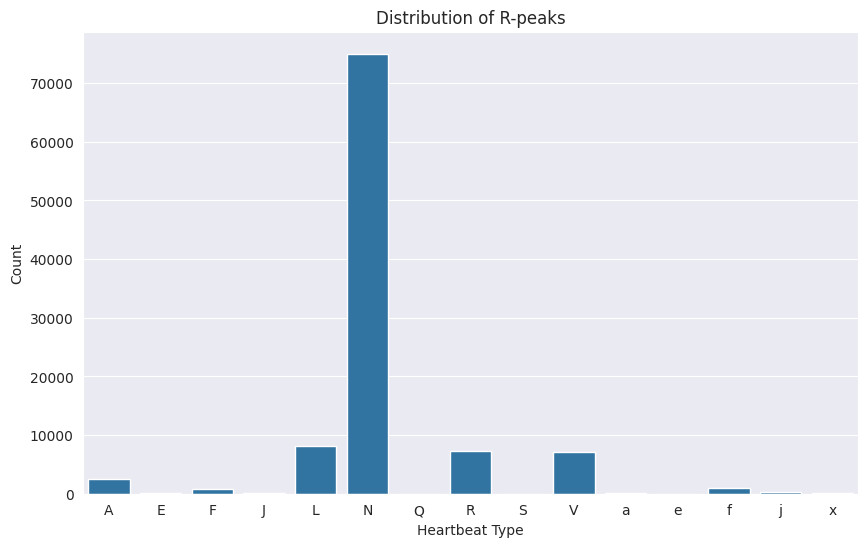

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x=y, order=np.unique(y))
plt.title('Distribution of R-peaks')
plt.xlabel('Heartbeat Type')
plt.ylabel('Count')
plt.show()

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(np.unique(y))

['A' 'E' 'F' 'J' 'L' 'N' 'Q' 'R' 'S' 'V' 'a' 'e' 'f' 'j' 'x']


In [4]:
print(np.unique(y_encoded))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


/home/sparsh/miniconda3/envs/tf_env/lib/python3.11/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 7 is too high: all coefficients will experience boundary effects.
  warnings.warn(


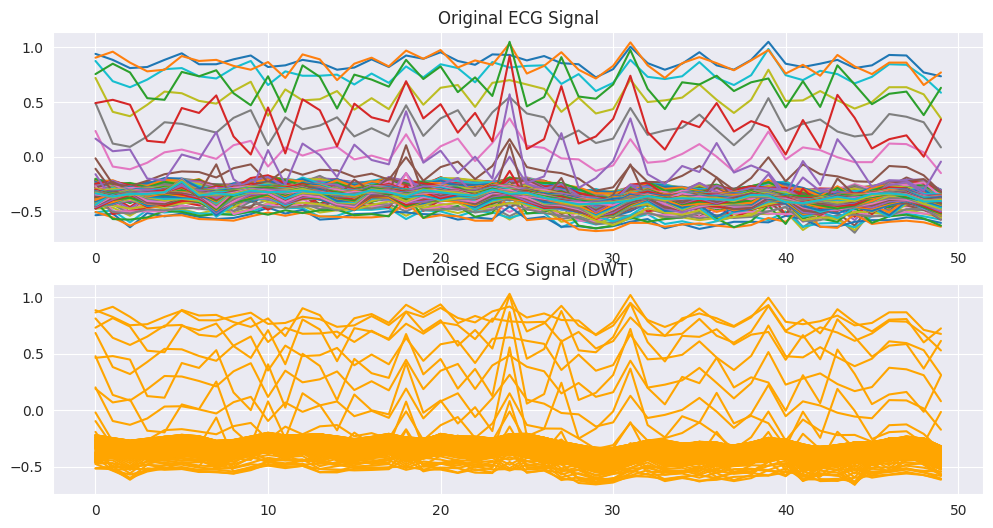

8


In [5]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

wavelet = 'db4'
levels = 7

# Decomposes X into cA4 and cD4-cD1; separates signal into frequency bands, with noice typically in high-frequency cD1-cD4
coeffs = pywt.wavedec(X, wavelet, level=levels)

# Estimates noise standrd deviation to set the thresholding level
sigma = np.median(np.abs(coeffs[-1])) / 0.6745

# Determines cutoff for suppressing noise in detail coefficients
thresold = sigma * np.sqrt(2 * np.log(len(X)))

# Applies soft thresholding to detail coefficients (cD4-cD1); removes noise (small coefficients) while preserving signal features
coeffs_threshold = [coeffs[0]] + [pywt.threshold(c, thresold, mode='soft') for c in coeffs[1:]]

denoised_X = pywt.waverec(coeffs_threshold, wavelet)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(X[:50], label='Original')
plt.title('Original ECG Signal')

plt.subplot(2, 1, 2)
plt.plot(denoised_X[:50], label='Denoised', color='orange')
plt.title('Denoised ECG Signal (DWT)')

plt.show()

print(len(coeffs))

In [6]:
from collections import Counter
import random
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Initial distribution
print("Initial class distribution:", Counter(y_encoded))

# Filter classes with at least 3 samples
valid_classes = [cls for cls, count in Counter(y_encoded).items() if count >= 3]
valid_mask = [label in valid_classes for label in y_encoded]
X_filtered, y_filtered = X[valid_mask], y_encoded[valid_mask]

# SMOTE: Reshape to 2D (samples, features) for SMOTE
n_samples = X_filtered.shape[0]  # Should be ~102606
X_2d = X_filtered.reshape(n_samples, -1)  # Shape: (n_samples, 360)

# Apply SMOTE
X_smote, y_smote = SMOTE(random_state=42).fit_resample(X_2d, y_filtered)
X_smote = X_smote.reshape(-1, 360, 1)  # Reshape back to (samples, 360, 1)

# Undersample Normal class (assuming 'N' is label 5)
normal_mask = y_smote == list(le.classes_).index('N')
normal_indices = random.sample(list(np.where(normal_mask)[0]), min(50000, sum(normal_mask)))
final_indices = normal_indices + list(np.where(~normal_mask)[0])

# Final balanced dataset
X_balanced, y_balanced = X_smote[final_indices], y_smote[final_indices]

# Train/val/test split (60-20-20)
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

print("Final distributions:")
print(f"Train: {Counter(y_train)}\nVal: {Counter(y_val)}\nTest: {Counter(y_test)}")

Initial class distribution: Counter({5: 75011, 4: 8071, 7: 7255, 9: 7129, 0: 2546, 12: 982, 2: 802, 13: 229, 14: 193, 10: 150, 1: 106, 3: 83, 6: 33, 11: 16, 8: 2})
Final distributions:
Train: Counter({9: 45007, 2: 45007, 1: 45007, 4: 45007, 13: 45007, 0: 45007, 14: 45007, 6: 45006, 7: 45006, 10: 45006, 12: 45006, 3: 45006, 11: 45006, 5: 30000})
Val: Counter({12: 15003, 3: 15003, 7: 15003, 10: 15002, 14: 15002, 9: 15002, 0: 15002, 4: 15002, 11: 15002, 1: 15002, 13: 15002, 2: 15002, 6: 15002, 5: 10000})
Test: Counter({6: 15003, 11: 15003, 10: 15003, 4: 15002, 13: 15002, 12: 15002, 1: 15002, 9: 15002, 7: 15002, 2: 15002, 14: 15002, 0: 15002, 3: 15002, 5: 10000})


In [7]:
import tensorflow as tf

# Build ANN
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(360,)),  # Layer 1
    tf.keras.layers.Dense(32, activation='relu'),                    # Layer 2
    tf.keras.layers.Dense(64, activation='relu'),                    # Layer 3
    tf.keras.layers.Dense(15, activation='softmax')          # Output layer
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Accuracy: {accuracy}")

2025-06-25 00:42:37.746653: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-25 00:42:37.789869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-25 00:42:37.804807: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-25 00:42:37.809163: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-25 00:42:37.851135: I tensorflow/core/platform/cpu_feature_guar

Epoch 1/50


I0000 00:00:1750792361.634550   36125 service.cc:146] XLA service 0x72b9f000a3b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750792361.634568   36125 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-06-25 00:42:41.658035: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-25 00:42:41.736546: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


  232/19222 ━━━━━━━━━━━━━━━━━━━━ 14s 749us/step - accuracy: 0.2867 - loss: 2.2636

I0000 00:00:1750792362.963474   36125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19222/19222 ━━━━━━━━━━━━━━━━━━━━ 21s 968us/step - accuracy: 0.8710 - loss: 0.4420 - val_accuracy: 0.9739 - val_loss: 0.0881
Epoch 2/50
19222/19222 ━━━━━━━━━━━━━━━━━━━━ 15s 784us/step - accuracy: 0.9731 - loss: 0.0911 - val_accuracy: 0.9798 - val_loss: 0.0693
Epoch 3/50
19222/19222 ━━━━━━━━━━━━━━━━━━━━ 16s 841us/step - accuracy: 0.9799 - loss: 0.0670 - val_accuracy: 0.9867 - val_loss: 0.0462
Epoch 4/50
19222/19222 ━━━━━━━━━━━━━━━━━━━━ 16s 815us/step - accuracy: 0.9833 - loss: 0.0554 - val_accuracy: 0.9875 - val_loss: 0.0413
Epoch 5/50
19222/19222 ━━━━━━━━━━━━━━━━━━━━ 14s 740us/step - accuracy: 0.9852 - loss: 0.0497 - val_accuracy: 0.9868 - val_loss: 0.0463
Epoch 6/50
19222/19222 ━━━━━━━━━━━━━━━━━━━━ 16s 808us/step - accuracy: 0.9866 - loss: 0.0450 - val_accuracy: 0.9878 - val_loss: 0.0411
Epoch 7/50
19222/19222 ━━━━━━━━━━━━━━━━━━━━ 16s 850us/step - accuracy: 0.9879 - loss: 0.0404 - val_accuracy: 0.9905 - val_loss: 0.0331
Epoch 8/50
19222/19222 ━━━━━━━━━━━━━━━━━━━━ 16s 830us/step - accur